# **Comparing diversity of sequence across the Covid MSA to language model uncertainty.**

Download coronavirus MSA

In [1]:
# Download the Figshare SARS-CoV-2 MSA dataset
!pip install gdown
import gdown

file_id = "1RHeifP_M0zpJtf9v7MD5VqXyD27I3YE9"
url = f"https://drive.google.com/uc?id={file_id}"

# Google Drive "shareable link" format:
output = "1"

gdown.download(url, output, quiet=False)

## Or download manually from:
# "https://figshare.com/ndownloader/articles/20486178/versions/1"

Downloading...
From (original): https://drive.google.com/uc?id=1RHeifP_M0zpJtf9v7MD5VqXyD27I3YE9
From (redirected): https://drive.google.com/uc?id=1RHeifP_M0zpJtf9v7MD5VqXyD27I3YE9&confirm=t&uuid=ced71701-c2db-482a-8544-ba89af7885ee
To: /content/1
100%|██████████| 813M/813M [00:04<00:00, 194MB/s]


'1'

In [2]:
!pip install torch biopython matplotlib seaborn scipy pandas tqdm


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, linregress
from transformers import AutoTokenizer, AutoModelForMaskedLM
from Bio import SeqIO
import zipfile
import os
from tqdm import tqdm
import warnings
import pandas as pd
import scipy.stats #import entropy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
def load_data(max_sequences=100):
    """Load aligned genome sequences"""
    if os.path.exists('1'):
        with zipfile.ZipFile('1', 'r') as zip_ref:
            zip_ref.extractall('sars_cov2_data')

    sequences = []
    msa_file = 'sars_cov2_data/MSA.fasta'

    for i, record in enumerate(SeqIO.parse(msa_file, "fasta")):
        sequences.append(str(record.seq))
        if i >= max_sequences - 1:
            break

    print(f"Loaded {len(sequences)} aligned genome sequences of length {len(sequences[0])}")
    return sequences

In [5]:
a = load_data(max_sequences=1)

Loaded 1 aligned genome sequences of length 29903


### Fit nucleotide transformer model to a single sequence

In [6]:
# Load model and tokenizer
model_name = "InstaDeepAI/nucleotide-transformer-500m-human-ref"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Reset CUDA and load model safely
torch.cuda.empty_cache()
model = AutoModelForMaskedLM.from_pretrained(model_name, torch_dtype=torch.float16)
model = model.cuda()

sequence = a[0].upper()

# Process sequence in chunks to avoid memory issues
chunk_size = 500  # Reduced chunk size
results = []

for start_idx in range(0, len(sequence), chunk_size):
    chunk = sequence[start_idx:start_idx + chunk_size]
    tokens = tokenizer(chunk, return_tensors="pt", padding=True, truncation=True, max_length=128)  # Reduced max_length
    input_ids = tokens['input_ids'].cuda()

    with torch.no_grad():
        outputs = model(**{k: v.cuda() for k, v in tokens.items()})
        probs = torch.softmax(outputs.logits, dim=-1)

    decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    for i, (token_id, token_str) in enumerate(zip(input_ids[0], decoded_tokens)):
        if token_str not in ['<cls>', '<sep>', '<pad>', '<eos>', '<unk>'] and token_id.item() < tokenizer.vocab_size:
            # Calculate position more accurately
            actual_pos = start_idx + max(0, i-1) * 6  # Assuming 6-mer tokens
            end_pos = min(actual_pos + 6, len(sequence))

            token_probs = probs[0, i].cpu().numpy()

            # Only get valid token probabilities (avoid out-of-bounds)
            valid_indices = min(len(token_probs), tokenizer.vocab_size)
            result_row = {
                'position': f"{actual_pos}:{end_pos}",
                'actual_token': token_str,
                'actual_prob': float(token_probs[token_id.item()])
            }

            # Only add probabilities for valid tokens
            for j in range(valid_indices):
                try:
                    token_name = tokenizer.convert_ids_to_tokens([j])[0]
                    result_row[f'prob_{token_name}'] = float(token_probs[j])
                except:
                    continue

            results.append(result_row)

    # Clear GPU memory
    del outputs, probs
    torch.cuda.empty_cache()

df = pd.DataFrame(results)
df.to_csv('nucleotide_predictions_all.csv', index=False)

actual_probs = df['actual_prob'].values
print(f"Mean probability of actual tokens: {actual_probs.mean():.4f}")
print(f"DataFrame shape: {df.shape}")
print(f"Sample rows:\n{df.head()}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

EsmForMaskedLM LOAD REPORT from: InstaDeepAI/nucleotide-transformer-500m-human-ref
Key                         | Status     |  | 
----------------------------+------------+--+-
esm.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Mean probability of actual tokens: 0.6203
DataFrame shape: (5083, 4108)
Sample rows:
  position actual_token  actual_prob  prob_<unk>  prob_<pad>  prob_<mask>  \
0      0:6       ATTAAA     0.919434         0.0         0.0          0.0   
1     6:12       GGTTTA     0.086975         0.0         0.0          0.0   
2    12:18       TACCTT     0.489990         0.0         0.0          0.0   
3    18:24       CCCAGG     0.931641         0.0         0.0          0.0   
4    24:30       TAACAA     0.315674         0.0         0.0          0.0   

   prob_<cls>   prob_AAAAAA   prob_AAAAAT   prob_AAAAAC  ...   prob_GGGGCG  \
0         0.0  2.458096e-04  1.798868e-04  2.568960e-05  ...  4.768372e-07   
1         0.0  2.109528e-03  1.165390e-03  4.897118e-04  ...  1.691580e-04   
2         0.0  1.997948e-04  1.250505e-04  3.192425e-04  ...  1.627207e-05   
3         0.0  6.556511e-07  4.768372e-07  1.788139e-07  ...  4.768372e-07   
4         0.0  3.675461e-03  2.173185e-04  2.094269e-03  ...  

### Calculate the language model entropy values at each token

In [7]:
# Read the predictions CSV
df = pd.read_csv('nucleotide_predictions_all.csv')

# Get all probability columns (excluding metadata)
prob_cols = [col for col in df.columns if col.startswith('prob_')]

# Calculate entropy for each token
entropies = []
for idx, row in df.iterrows():
    # Get probability values for this token
    probs = [row[col] for col in prob_cols]
    probs = np.array(probs)

    # Remove zeros and normalize to avoid log(0)
    probs = probs[probs > 0]
    probs = probs / probs.sum()  # Normalize

    # Calculate Shannon entropy: H = -sum(p * log2(p))
    entropy = -np.sum(probs * np.log2(probs))
    entropies.append(entropy)

# Parse position ranges to get start and end indices
start_positions = []
end_positions = []
for pos in df['position']:
    start, end = map(int, pos.split(':'))
    start_positions.append(start)
    end_positions.append(end)

# Create entropy dataframe
entropy_df = pd.DataFrame({
    'start_position': start_positions,
    'end_position': end_positions,
    'token': df['actual_token'],
    'entropy': entropies,
    'actual_token_prob': df['actual_prob']
})

# Save entropy results
entropy_df.to_csv('token_entropy.csv', index=False)

print(f"Entropy statistics:")
print(f"Mean entropy: {np.mean(entropies):.4f}")
print(f"Min entropy: {np.min(entropies):.4f}")
print(f"Max entropy: {np.max(entropies):.4f}")
print(f"Std entropy: {np.std(entropies):.4f}")
print(f"\nSample results:")
print(entropy_df.head(10))

Entropy statistics:
Mean entropy: 4.2954
Min entropy: 0.0201
Max entropy: 11.5606
Std entropy: 3.6538

Sample results:
   start_position  end_position   token    entropy  actual_token_prob
0               0             6  ATTAAA   1.022077           0.919434
1               6            12  GGTTTA  10.101479           0.086975
2              12            18  TACCTT   5.864629           0.489990
3              18            24  CCCAGG   0.763092           0.931641
4              24            30  TAACAA   7.844767           0.315674
5              30            36  ACCAAC   9.476963           0.182617
6              36            42  CAACTT  10.220279           0.085449
7              42            48  TCGATC   9.815570           0.082886
8              48            54  TCTTGT   9.684617           0.162720
9              54            60  AGATCT   5.945099           0.399414


### Calculate MSA entropies for each token.

In [8]:
def entropy_chunks_data(positions_csv='positions.csv', max_sequences=100):
    """Load aligned genome sequences and calculate entropy for specified nucleotide chunks"""
    if os.path.exists('1'):
        with zipfile.ZipFile('1', 'r') as zip_ref:
            zip_ref.extractall('sars_cov2_data')

    # Load position ranges
    positions_df = pd.read_csv(positions_csv)
    msa_file = 'sars_cov2_data/MSA.fasta'

    # Load all sequences (needed for chunk comparison)
    sequences = []
    for i, record in enumerate(SeqIO.parse(msa_file, "fasta")):
        if i >= max_sequences:
            break
        sequences.append(str(record.seq))

    # Calculate entropy for each chunk
    results = []
    for _, row in positions_df.iterrows():
        start, end = int(row['start_position']), int(row['end_position'])

        # Extract chunks from all sequences
        chunks = [seq[start:end] for seq in sequences]

        # Count chunk frequencies and calculate entropy
        chunk_counts = list(Counter(chunks).values())
        chunk_entropy = scipy.stats.entropy(chunk_counts)

        results.append({
            'start_position': start,
            'end_position': end,
            'chunk_length': len(chunks[0]),
            'entropy': chunk_entropy
        })

    # Save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv('chunk_entropy.csv', index=False)

    print(f"Calculated chunk entropy for {len(sequences)} sequences")
    print(f"Processed {len(results)} chunks, saved to chunk_entropy.csv")
    return results_df

In [9]:
entropy_chunks_data(positions_csv='token_entropy.csv', max_sequences=100000)

Calculated chunk entropy for 26646 sequences
Processed 5083 chunks, saved to chunk_entropy.csv


,start_position,end_position,chunk_length,entropy
0,0,6,6,0.675815
1,6,12,6,0.657188
2,12,18,6,0.673799
3,18,24,6,0.734824
4,24,30,6,0.884216
...,...,...,...,...
5078,29878,29884,6,0.566455
5079,29884,29890,6,0.549198
5080,29890,29896,6,0.530182
5081,29896,29902,6,0.531917


### Plot LM diagnostics

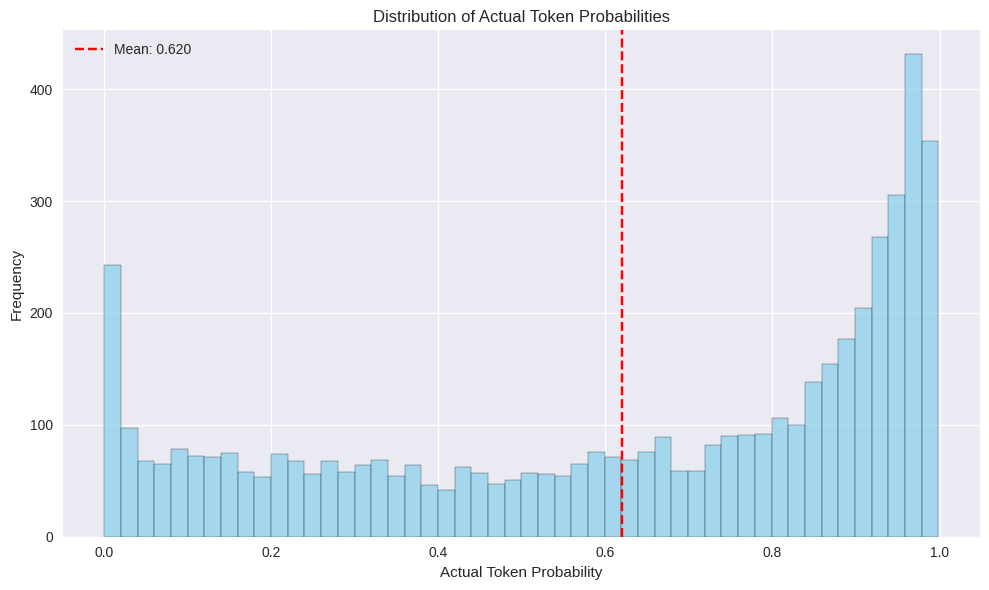

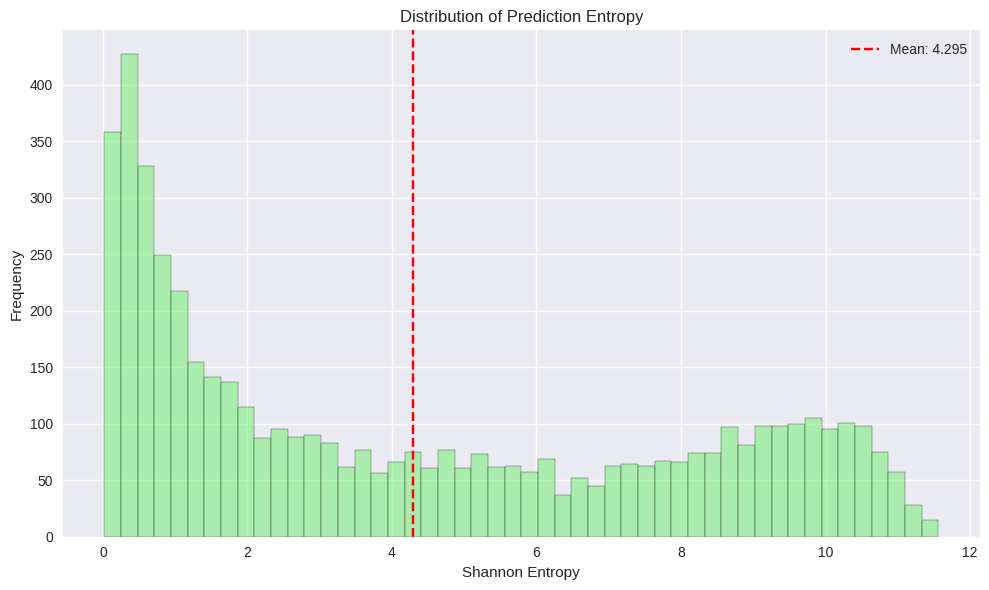

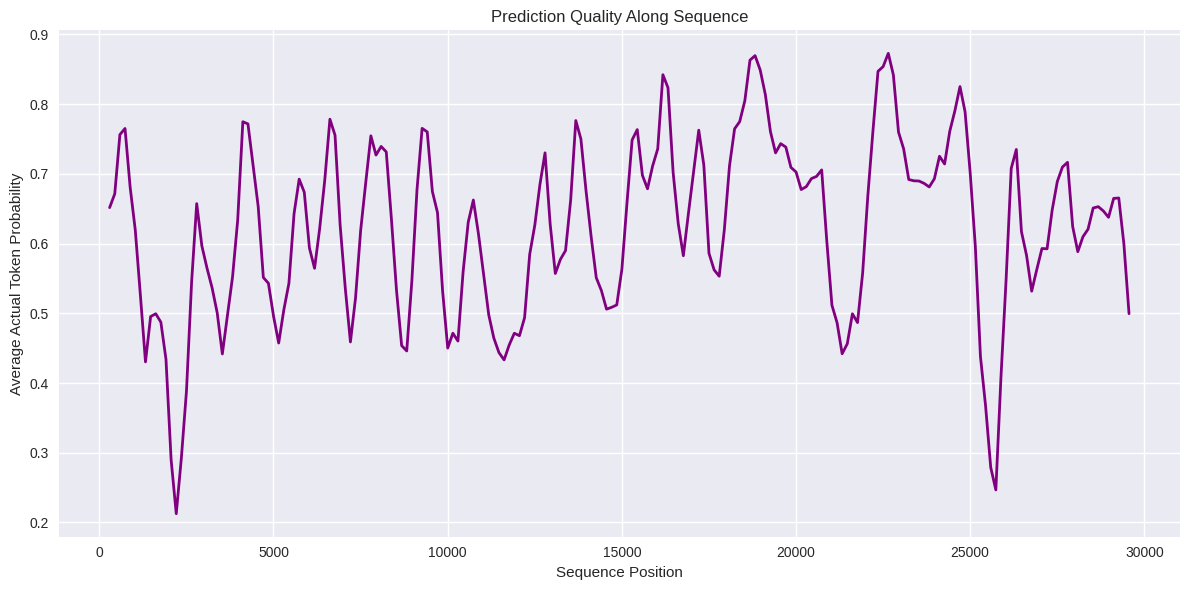

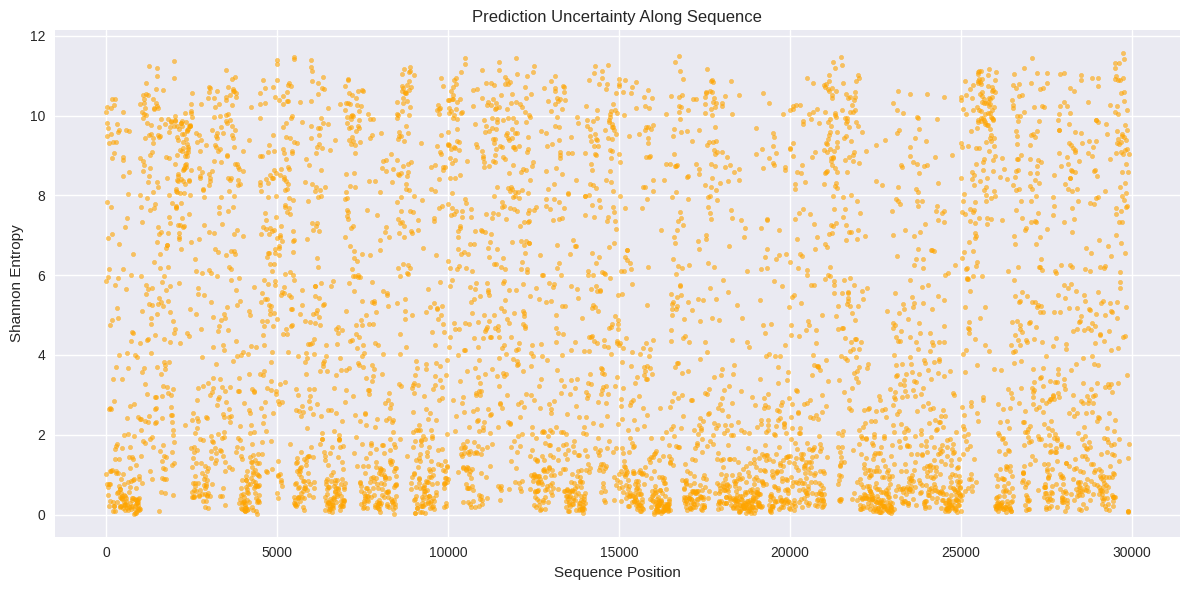

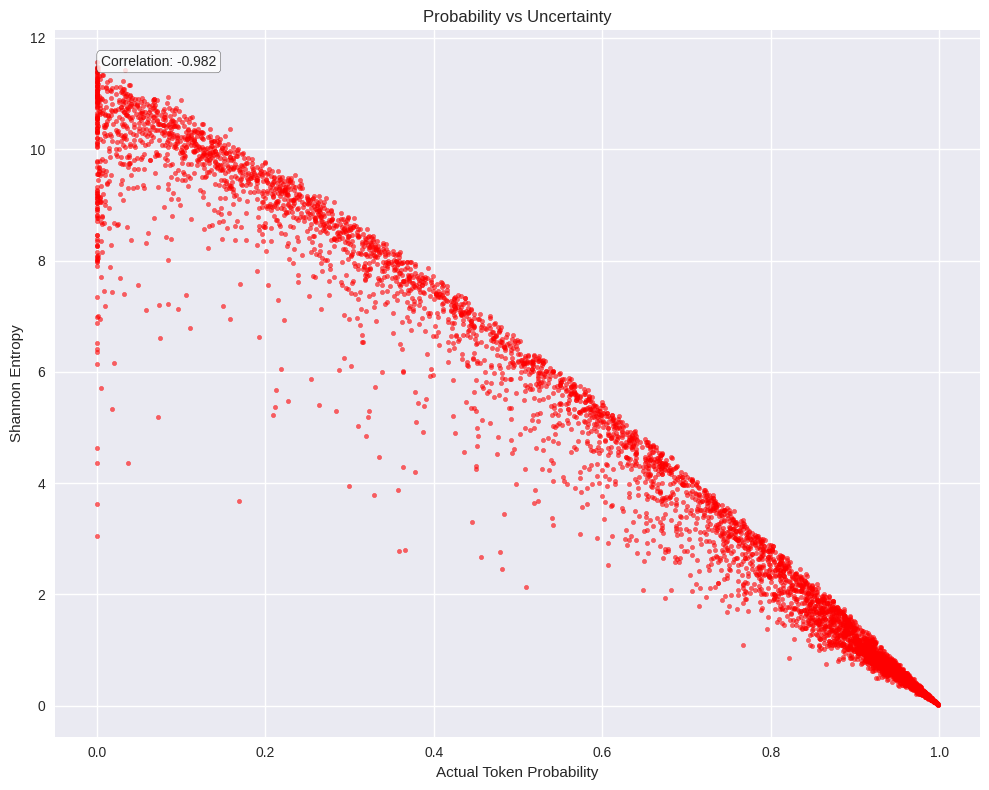

<Figure size 1200x600 with 0 Axes>

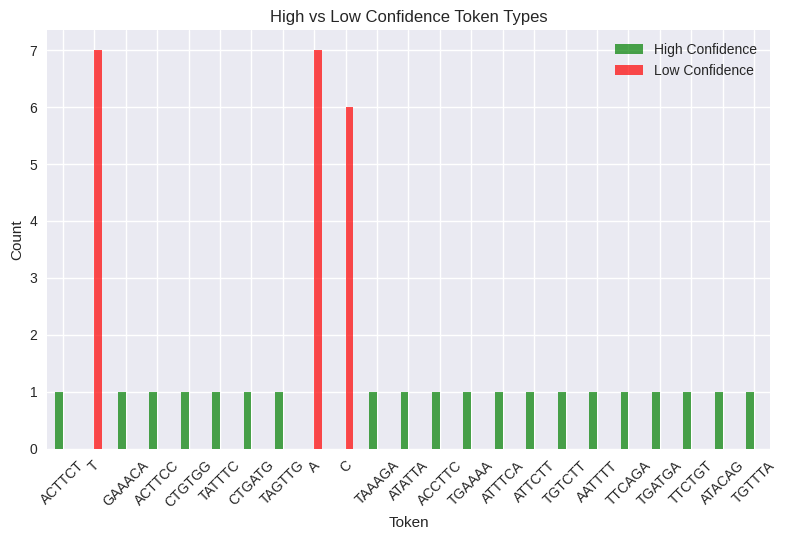

=== LANGUAGE MODEL PERFORMANCE SUMMARY ===
Total tokens analyzed: 5083
Mean actual token probability: 0.6203
Median actual token probability: 0.7314
Mean entropy: 4.2954
Tokens with >50% probability: 3320 (65.3%)
Tokens with >90% probability: 1544 (30.4%)
Probability-Entropy correlation: -0.9820

Plots saved as separate PNG files and summary to 'lm_performance_summary.csv'


In [10]:
# Read the predictions and entropy CSVs
df = pd.read_csv('nucleotide_predictions_all.csv')
entropy_df = pd.read_csv('token_entropy.csv')

# Parse positions for plotting
positions = []
for pos in df['position']:
    start, end = map(int, pos.split(':'))
    positions.append(start)
df['start_pos'] = positions

# Merge dataframes using start_pos
df_merged = df.merge(entropy_df[['start_position', 'entropy']], left_on='start_pos', right_on='start_position', how='left')

plt.style.use('seaborn-v0_8')

# Plot 1: Actual token probability distribution
plt.figure(figsize=(10, 6))
plt.hist(df['actual_prob'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Actual Token Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Token Probabilities')
plt.axvline(df['actual_prob'].mean(), color='red', linestyle='--', label=f'Mean: {df["actual_prob"].mean():.3f}')
plt.legend()
plt.tight_layout()
plt.savefig('plot1_probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Entropy distribution
plt.figure(figsize=(10, 6))
plt.hist(entropy_df['entropy'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Shannon Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Entropy')
plt.axvline(entropy_df['entropy'].mean(), color='red', linestyle='--', label=f'Mean: {entropy_df["entropy"].mean():.3f}')
plt.legend()
plt.tight_layout()
plt.savefig('plot2_entropy_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Probability vs Position (sliding window)
plt.figure(figsize=(12, 6))
window_size = 100
if len(df_merged) > window_size:
    windowed_probs = [df_merged['actual_prob'].iloc[i:i+window_size].mean()
                     for i in range(0, len(df_merged)-window_size, window_size//4)]
    windowed_positions = [df_merged['start_pos'].iloc[i:i+window_size].mean()
                         for i in range(0, len(df_merged)-window_size, window_size//4)]
    plt.plot(windowed_positions, windowed_probs, linewidth=2, color='purple')
else:
    plt.scatter(df_merged['start_pos'], df_merged['actual_prob'], alpha=0.6, color='purple')
plt.xlabel('Sequence Position')
plt.ylabel('Average Actual Token Probability')
plt.title('Prediction Quality Along Sequence')
plt.tight_layout()
plt.savefig('plot3_quality_along_sequence.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Entropy vs Position
plt.figure(figsize=(12, 6))
plt.scatter(entropy_df['start_position'], entropy_df['entropy'], alpha=0.6, color='orange', s=10)
plt.xlabel('Sequence Position')
plt.ylabel('Shannon Entropy')
plt.title('Prediction Uncertainty Along Sequence')
plt.tight_layout()
plt.savefig('plot4_entropy_along_sequence.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 5: Probability vs Entropy scatter
plt.figure(figsize=(10, 8))
plt.scatter(entropy_df['actual_token_prob'], entropy_df['entropy'], alpha=0.6, color='red', s=10)
plt.xlabel('Actual Token Probability')
plt.ylabel('Shannon Entropy')
plt.title('Probability vs Uncertainty')
corr = stats.pearsonr(entropy_df['actual_token_prob'], entropy_df['entropy'])[0]
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.savefig('plot5_probability_vs_entropy.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 6: Top vs bottom performing tokens
plt.figure(figsize=(12, 6))
top_tokens = df.nlargest(20, 'actual_prob')['actual_token'].value_counts()
bottom_tokens = df.nsmallest(20, 'actual_prob')['actual_token'].value_counts()

# Get union of all tokens and reindex both series
all_tokens = list(set(top_tokens.index) | set(bottom_tokens.index))
top_reindexed = top_tokens.reindex(all_tokens, fill_value=0)
bottom_reindexed = bottom_tokens.reindex(all_tokens, fill_value=0)

token_performance = pd.DataFrame({
    'high_conf': top_reindexed,
    'low_conf': bottom_reindexed
})

token_performance.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.xlabel('Token')
plt.ylabel('Count')
plt.title('High vs Low Confidence Token Types')
plt.legend(['High Confidence', 'Low Confidence'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plot6_token_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("=== LANGUAGE MODEL PERFORMANCE SUMMARY ===")
print(f"Total tokens analyzed: {len(df)}")
print(f"Mean actual token probability: {df['actual_prob'].mean():.4f}")
print(f"Median actual token probability: {df['actual_prob'].median():.4f}")
print(f"Mean entropy: {entropy_df['entropy'].mean():.4f}")
print(f"Tokens with >50% probability: {(df['actual_prob'] > 0.5).sum()} ({(df['actual_prob'] > 0.5).mean()*100:.1f}%)")
print(f"Tokens with >90% probability: {(df['actual_prob'] > 0.9).sum()} ({(df['actual_prob'] > 0.9).mean()*100:.1f}%)")
print(f"Probability-Entropy correlation: {stats.pearsonr(entropy_df['actual_token_prob'], entropy_df['entropy'])[0]:.4f}")

# Save summary stats
summary_stats = {
    'total_tokens': len(df),
    'mean_prob': df['actual_prob'].mean(),
    'median_prob': df['actual_prob'].median(),
    'mean_entropy': entropy_df['entropy'].mean(),
    'high_conf_tokens_50pct': (df['actual_prob'] > 0.5).sum(),
    'high_conf_tokens_90pct': (df['actual_prob'] > 0.9).sum(),
    'prob_entropy_correlation': stats.pearsonr(entropy_df['actual_token_prob'], entropy_df['entropy'])[0]
}

pd.DataFrame([summary_stats]).to_csv('lm_performance_summary.csv', index=False)
print(f"\nPlots saved as separate PNG files and summary to 'lm_performance_summary.csv'")

### Plot regression of LM vs MSA entropies, and find correlations between non-overlapping windows.

In [11]:
# Setup
output_folder = 'entropy_output_2'
os.makedirs(output_folder, exist_ok=True)
msa = pd.read_csv('chunk_entropy.csv')
lm = pd.read_csv('token_entropy.csv')

# Check positions match
print("Position match:", set(zip(msa.start_position, msa.end_position)) == set(zip(lm.start_position, lm.end_position)))

# Merge data
df = pd.merge(msa, lm, on=['start_position', 'end_position'], suffixes=('_msa', '_lm'))

# 1. Scatter plot with regression
plt.figure(figsize=(8, 6))
x, y = df.entropy_msa, df.entropy_lm
slope, intercept, r_value, _, _ = linregress(x, y)
plt.scatter(x, y, alpha=0.6)
plt.plot(x, slope*x + intercept, 'r-', linewidth=2)
plt.xlabel('MSA Entropy')
plt.ylabel('LM Entropy')
plt.title(f'MSA vs LM Entropy (R² = {r_value**2:.3f})')
plt.savefig(f'{output_folder}/scatter_regression.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Moving averages and correlations for different window sizes
windows = [2,5,10,20,30,40, 50, 100, 500, 1000]
correlations = {}
divergent_regions = {}
nonoverlap_results = {}

for w in windows:
    # Calculate moving averages (overlapping) - for visualization only
    msa_ma = df.entropy_msa.rolling(w, center=True).mean()
    lm_ma = df.entropy_lm.rolling(w, center=True).mean()

    # Calculate correlation for overlapping windows (biased, for visualization)
    valid = ~(msa_ma.isna() | lm_ma.isna())
    corr_overlap, p_overlap = pearsonr(msa_ma[valid], lm_ma[valid])
    correlations[w] = corr_overlap

    # Non-overlapping windows analysis (UNBIASED for statistics)
    n_windows = len(df) // w
    msa_nonoverlap = []
    lm_nonoverlap = []

    for i in range(n_windows):
        start_idx = i * w
        end_idx = start_idx + w
        msa_nonoverlap.append(df.entropy_msa.iloc[start_idx:end_idx].mean())
        lm_nonoverlap.append(df.entropy_lm.iloc[start_idx:end_idx].mean())

    msa_nonoverlap = np.array(msa_nonoverlap)
    lm_nonoverlap = np.array(lm_nonoverlap)

    # TRUE correlation and significance (non-overlapping)
    corr_true, p_true = pearsonr(msa_nonoverlap, lm_nonoverlap)
    sig_threshold = 1.96 / np.sqrt(n_windows - 3) if n_windows > 3 else np.nan
    is_significant = abs(corr_true) > sig_threshold if not np.isnan(sig_threshold) else False

    nonoverlap_results[w] = {
        'correlation': corr_true,
        'p_value': p_true,
        'n_windows': n_windows,
        'threshold': sig_threshold,
        'is_significant': is_significant
    }

    # Scatter plot for non-overlapping windows
    slope_no, intercept_no, r_no, p_no, _ = linregress(msa_nonoverlap, lm_nonoverlap)

    plt.figure(figsize=(8, 6))
    plt.scatter(msa_nonoverlap, lm_nonoverlap, alpha=0.7, s=50)
    plt.plot(msa_nonoverlap, slope_no*msa_nonoverlap + intercept_no, 'r-', linewidth=2)
    plt.xlabel('MSA Entropy (averaged)')
    plt.ylabel('LM Entropy (averaged)')
    sig_text = "***" if p_true < 0.001 else "**" if p_true < 0.01 else "*" if p_true < 0.05 else "ns"
    plt.title(f'Non-overlapping windows (size={w})\nR² = {r_no**2:.3f}, n = {n_windows}, p = {p_true:.3e} {sig_text}')
    plt.savefig(f'{output_folder}/scatter_nonoverlap_w{w}.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Find divergent regions (top 5% of absolute differences)
    diff = np.abs(msa_ma - lm_ma)
    threshold_div = diff.quantile(0.95)
    divergent_idx = diff > threshold_div
    divergent_regions[w] = df.loc[divergent_idx, ['start_position', 'end_position']].values

    # Plot separate traces
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(msa_ma, label='MSA', alpha=0.7)
    plt.plot(lm_ma, label='LM', alpha=0.7)
    plt.title(f'Separate traces (window={w})')
    plt.legend()

    # Plot normalized together
    plt.subplot(1, 2, 2)
    msa_norm = (msa_ma - msa_ma.min()) / (msa_ma.max() - msa_ma.min())
    lm_norm = (lm_ma - lm_ma.min()) / (lm_ma.max() - lm_ma.min())
    plt.plot(msa_norm, label='MSA (normalized)', alpha=0.7)
    plt.plot(lm_norm, label='LM (normalized)', alpha=0.7)
    plt.title(f'Normalized traces (window={w})\nOverlapping r={corr_overlap:.3f} | Independent r={corr_true:.3f} {sig_text}')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{output_folder}/traces_window_{w}.png', dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Window {w}: Overlapping r={corr_overlap:.3f} (BIASED) | Independent r={corr_true:.3f} (p={p_true:.3e}) n={n_windows} {sig_text}")

# Summary plot of correlations vs window size
plt.figure(figsize=(10, 6))
overlap_corrs = list(correlations.values())
indep_corrs = [nonoverlap_results[w]['correlation'] for w in windows]

plt.plot(windows, overlap_corrs, 'o-', linewidth=2, markersize=8, label='Overlapping (biased)', alpha=0.7)
plt.plot(windows, indep_corrs, 's-', linewidth=2, markersize=8, label='Independent (unbiased)')
plt.xlabel('Window Size')
plt.ylabel('Correlation')
plt.title('Correlation vs Window Size')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'{output_folder}/correlation_vs_window.png', dpi=300, bbox_inches='tight')
plt.close()

# Save results
results = pd.DataFrame({
    'window_size': windows,
    'overlapping_correlation': [correlations[w] for w in windows],
    'independent_correlation': [nonoverlap_results[w]['correlation'] for w in windows],
    'p_value': [nonoverlap_results[w]['p_value'] for w in windows],
    'n_windows': [nonoverlap_results[w]['n_windows'] for w in windows],
    'significance_threshold': [nonoverlap_results[w]['threshold'] for w in windows],
    'is_significant': [nonoverlap_results[w]['is_significant'] for w in windows],
    'num_divergent_regions': [len(divergent_regions[w]) for w in windows]
})
results.to_csv(f'{output_folder}/analysis_summary.csv', index=False)

print(f"\nAnalysis complete! Results saved in '{output_folder}/' folder")
print(f"Overall correlation: {pearsonr(df.entropy_msa, df.entropy_lm)[0]:.3f}")
print("\nTrue Significance Summary (Non-overlapping):")
print(results[['window_size', 'independent_correlation', 'p_value', 'n_windows', 'is_significant']])

print(f"\nWhy p-values were misleading:")
print("- Overlapping windows violate independence assumption")
print("- Each rolling average shares most data with neighbors")
print("- This inflates sample size and deflates p-values artificially")
print("- Non-overlapping analysis gives TRUE statistical significance")

Position match: True
Window 2: Overlapping r=0.097 (BIASED) | Independent r=0.097 (p=1.013e-06) n=2541 ***
Window 5: Overlapping r=0.105 (BIASED) | Independent r=0.103 (p=1.028e-03) n=1016 **
Window 10: Overlapping r=0.114 (BIASED) | Independent r=0.112 (p=1.185e-02) n=508 *
Window 20: Overlapping r=0.139 (BIASED) | Independent r=0.115 (p=6.692e-02) n=254 ns
Window 30: Overlapping r=0.160 (BIASED) | Independent r=0.146 (p=5.866e-02) n=169 ns
Window 40: Overlapping r=0.158 (BIASED) | Independent r=0.164 (p=6.600e-02) n=127 ns
Window 50: Overlapping r=0.154 (BIASED) | Independent r=0.075 (p=4.558e-01) n=101 ns
Window 100: Overlapping r=0.092 (BIASED) | Independent r=-0.005 (p=9.732e-01) n=50 ns
Window 500: Overlapping r=0.082 (BIASED) | Independent r=0.440 (p=2.028e-01) n=10 ns
Window 1000: Overlapping r=-0.003 (BIASED) | Independent r=0.489 (p=4.031e-01) n=5 ns

Analysis complete! Results saved in 'entropy_output_2/' folder
Overall correlation: 0.091

True Significance Summary (Non-over

### Find regions enriched for low MSA, high LM entropy.

In [12]:
# Identify outliers: Low LM entropy + High MSA entropy
lm_threshold = np.percentile(df.entropy_lm, 75)
msa_threshold = np.percentile(df.entropy_msa, 25)
outliers = df[(df.entropy_lm >= lm_threshold) & (df.entropy_msa <= msa_threshold)]
# outliers = df[(df.entropy_msa <= msa_threshold)]
output_folder = 'low_msa_high_lm'
os.makedirs(output_folder, exist_ok=True)

# print(f"Found {len(outliers)} outliers (Low LM + High MSA)")

# Plot analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# 1. Scatter with outliers highlighted
ax1.scatter(df.entropy_msa, df.entropy_lm, alpha=0.5, s=15, color='lightblue')
ax1.scatter(outliers.entropy_msa, outliers.entropy_lm, s=30, color='red', label=f'n={len(outliers)}')
ax1.axhline(lm_threshold, color='red', linestyle='--', alpha=0.7)
ax1.axvline(msa_threshold, color='red', linestyle='--', alpha=0.7)
ax1.set_xlabel('MSA Entropy')
ax1.set_ylabel('LM Entropy')
ax1.set_title('Outliers: Low MSA, High LM')
ax1.legend()

# 2. Genomic distribution
outlier_pos = (outliers.start_position + outliers.end_position) / 2
ax2.hist(outlier_pos, bins=30, alpha=0.7, color='red')
ax2.set_xlabel('Genomic Position')
ax2.set_ylabel('Count')
ax2.set_title('Outlier Distribution')

# 3. Enrichment across genome segments
n_seg = 20
seg_size = df.end_position.max() / n_seg
expected_rate = len(outliers) / len(df)

enrichments = []
p_vals = []
for i in range(n_seg):
    start, end = i * seg_size, (i+1) * seg_size
    seg_outliers = len(outliers[(outlier_pos >= start) & (outlier_pos < end)])
    seg_total = len(df[((df.start_position + df.end_position)/2 >= start) &
                      ((df.start_position + df.end_position)/2 < end)])

    if seg_total > 0:
        obs_rate = seg_outliers / seg_total
        enrichment = obs_rate / expected_rate if expected_rate > 0 else 0
        p_val = stats.binomtest(seg_outliers, seg_total, expected_rate, alternative='greater')
    else:
        enrichment, p_val = 0, 1

    enrichments.append(enrichment)
    p_vals.append(p_val)

colors = ['red' if p.pvalue < 0.05 else 'blue' for p in p_vals]
seg_centers = [(i + 0.5) * seg_size for i in range(n_seg)]
ax3.bar(seg_centers, enrichments, width=seg_size*0.8, color=colors, alpha=0.7)
ax3.axhline(1, color='black', linestyle='-', alpha=0.5)
ax3.set_xlabel('Genomic Position')
ax3.set_ylabel('Enrichment')
ax3.set_title('Enrichment (Red=p<0.05)')

# 4. Cumulative distribution
all_pos = (df.start_position + df.end_position) / 2
ks_stat, ks_p = stats.ks_2samp(all_pos, outlier_pos)
ax4.hist(all_pos, bins=50, alpha=0.5, density=True, cumulative=True, label='All')
ax4.hist(outlier_pos, bins=20, alpha=0.7, density=True, cumulative=True, label='Outliers', color='red')
ax4.set_xlabel('Genomic Position')
ax4.set_ylabel('Cumulative Density')
ax4.set_title(f'Distribution (KS p={ks_p:.2e})')
ax4.legend()

plt.tight_layout()
plt.savefig(f'{output_folder}/outlier_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# Save results
outliers.to_csv(f'{output_folder}/outliers.csv', index=False)
print(f"KS test p-value: {ks_p:.2e}")
sig_enriched = [(i, enrichments[i]) for i, p in enumerate(p_vals) if p.pvalue < 0.05 and enrichments[i] > 1.5]
if sig_enriched:
    print("Enriched regions:", [(f"{i*seg_size:.0f}-{(i+1)*seg_size:.0f}", f"{e:.1f}x") for i, e in sig_enriched])
else:
    print("No significant enrichment")

KS test p-value: 8.84e-05
Enriched regions: [('10466-11961', '2.0x'), ('11961-13456', '2.0x'), ('13456-14952', '1.7x')]
